## Reinforcement learning with Quadcopter

In [1]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

In [2]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from tasks.basic import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

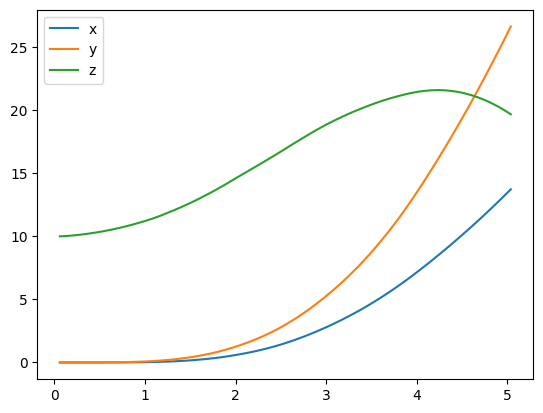

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

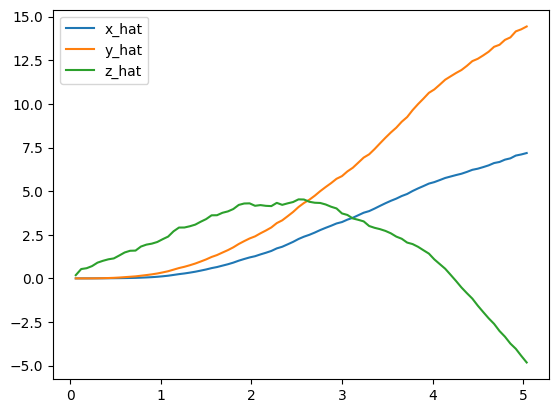

In [4]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

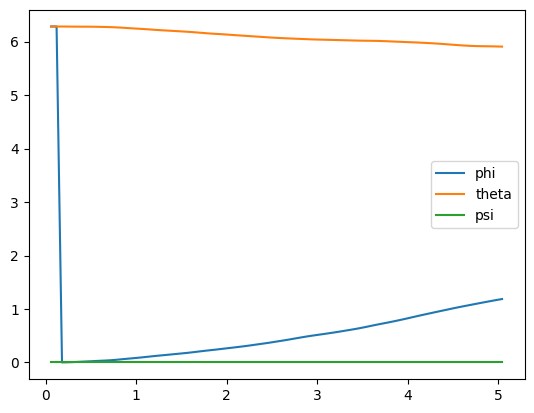

In [5]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

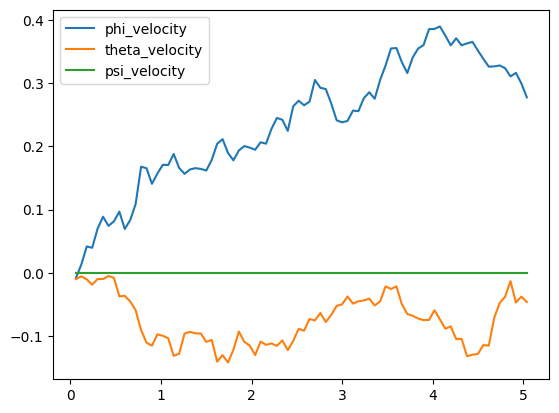

In [6]:

plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

### Task and Agent

In [7]:
# Import agents & tasks
from agents.policy_search import PolicySearch_Agent
from agents.ddpg import DDPG_Agent
import sys
import pandas as pd

num_episodes = 1000
target_pos = np.array([0., 0., 0.])
#task = Task(target_pos=target_pos)
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode = 1000, score =  -3.114 (best =  -2.637), noise_scale = 3.25

## Define the Task, Design the Agent, and Train the Agent

In [8]:
import os
import pickle
from tasks.basic import Task
from tasks.takeoff import Task_takeoff

exportPath = './simulation/'
if not os.path.exists(exportPath):
    os.makedirs(exportPath)

# z axis is up
init_pose = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) 
target_pos = np.array([0.0, 0.0, 10.0])
task = Task_takeoff(init_pose=init_pose, target_pos=target_pos, runtime=5.0)
agent = DDPG_Agent(task)
# number of episodes to train
num_episodes = 1000

2023-07-21 15:53:58.648827: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-07-21 15:53:58.648849: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-07-21 15:53:58.648855: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-07-21 15:53:58.648883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-21 15:53:58.648897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_mean/Mean:0', description="created by layer 'tf.math.reduce_mean'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.

In [ ]:
# before training
resultsAll = []
high_score = -1000000.0
low_score = 1000000.0

training_results = {'score': [],'episode': []}
for i_episode in range(1, num_episodes+1):
    # start a new episode
    state = agent.reset_episode() 
    score = 0

    episode_results = {
        'time': [],
        'x': [],
        'y': [],
        'z': [],
        'phi': [],
        'theta': [],
        'psi': [],
        'vx': [],
        'vy': [],
        'vz': [],
        'reward': [],
        }

    while True:
        action = agent.act(state)
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done)
        state = next_state
        score += reward
        high_score = max(high_score, score)
        low_score = min(low_score, score)

        # track the results for offline analysis
        episode_results['time'].append(task.sim.time)
        episode_results['x'].append(state[0])
        episode_results['y'].append(state[1])
        episode_results['z'].append(state[2])
        episode_results['phi'].append(state[3])
        episode_results['theta'].append(state[4])
        episode_results['psi'].append(state[5])
        episode_results['vx'].append(state[6])
        episode_results['vy'].append(state[7])
        episode_results['vz'].append(state[8])
        episode_results['reward'].append(reward)
        
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f}, low score = {:7.3f}, high score = {:7.3f}".format(i_episode, score, low_score, high_score), end="")
            training_results['episode'].append(i_episode)
            training_results['score'].append(score)
            break

    resultsAll.append(episode_results)

    sys.stdout.flush()

# save results for later analysis
with open("{}results.bin".format(exportPath), 'wb') as pickleFile:
    pickle.dump(resultsAll, pickleFile)

In [ ]:
## Render top result
with open("{}results.bin".format(exportPath), 'rb') as pickleFile:
    results = pickle.load(pickleFile)

# Sort wrt episode reward
episodeRewards = [np.sum(r['reward']) for r in results]
resultIndices = np.argsort(episodeRewards)

# Get top results
resultIndices = list(reversed(resultIndices))[0:1]

In [ ]:

# Plot reward for top result
for iE, e in enumerate(resultIndices):
    res = results[e]
    
    # plot reward
    plt.plot(res['time'], res['reward'], label='reward')
    plt.legend()
    _ = plt.ylim()

In [ ]:
## Generate visualisation
# Based on: https://github.com/craig-martinson/quadcopter-project/blob/master/visualise.py
from visualise import Quadrotor
from IPython.display import Image
import os
import imageio

images = []

for iE, e in enumerate(resultIndices):
    res = results[e] 
   
    filepath = "{}frame{:04}_{:04}.png".format(exportPath, iE, 0)
    
    q = Quadrotor(x=res['x'][0], 
            y=res['y'][0], 
            z=res['z'][0], 
            roll=res['phi'][0],
            pitch=res['theta'][0], 
            yaw=res['psi'][0],
            reward=res['reward'][0], 
            title=None,
            filepath=filepath)
    
    q.set_target(target_pos[0], target_pos[1], target_pos[2])
    
    # Render all frames in this episode
    for i in range(1, len(res['x'])):
        filepath = "{}frame{:04}_{:04}.png".format(exportPath, iE, i)
        
        q.update_pose(x=res['x'][i], 
        y=res['y'][i], 
        z=res['z'][i], 
        roll=res['phi'][i],
        pitch=res['theta'][i], 
        yaw=res['psi'][i],
        reward=res['reward'][i],
        title=None,
        filepath=filepath)
        
        images.append(imageio.imread(filepath))
        
    q.close()   
    
# Save all frames to animated gif
imageio.mimsave("{}flight.gif".format(exportPath), images)

In [ ]:
# Render animated gif
with open("{}flight.gif".format(exportPath), 'rb') as f:
    display(Image(data=f.read(), format='png'))